## Individuell uppgift – Hälsostudie

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv("data/health_study_dataset.csv")

#df.head()
#df.info()

### Beskrivande analys

In [2]:
# Beskrivande analys

desc = (df[["age", "height", "weight", "systolic_bp", "cholesterol"]]
        .agg(['mean', 'median', 'min', 'max'])
)

print(desc)

             age     height   weight  systolic_bp  cholesterol
mean    49.42625  171.84925   73.413   149.178625      4.92915
median  50.00000  171.35000   73.200   149.400000      4.97000
min     18.00000  144.40000   33.700   106.800000      2.50000
max     90.00000  200.40000  114.400   185.900000      7.88000


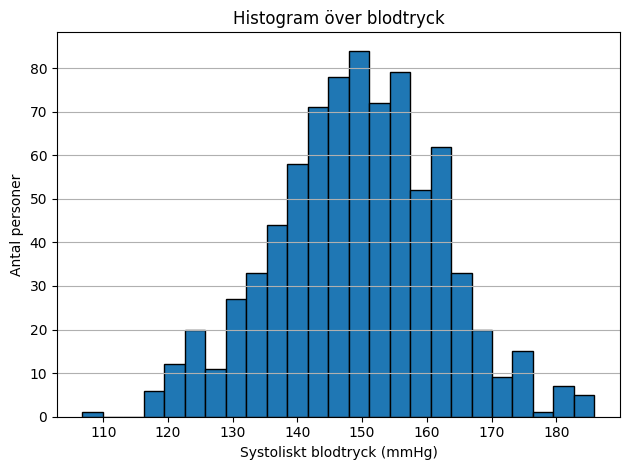

In [3]:
# Histogram över blodtryck

fig, ax = plt.subplots()
ax.hist(df["systolic_bp"], bins = 25, edgecolor = 'black')
ax.set_title('Histogram över blodtryck')
ax.set_xlabel('Systoliskt blodtryck (mmHg)')
ax.set_ylabel('Antal personer')
ax.grid(axis='y')
plt.tight_layout()
plt.show()

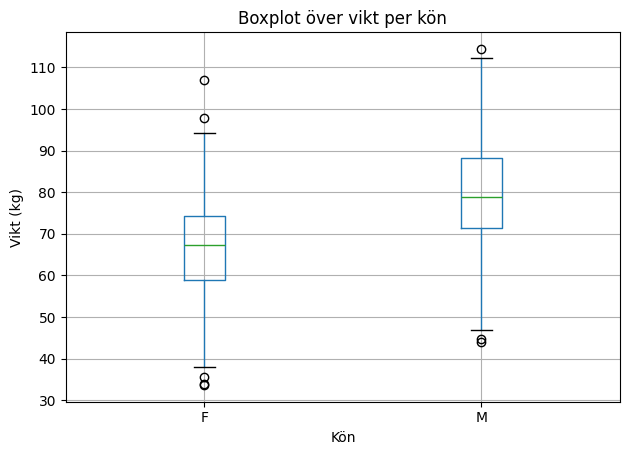

In [4]:
# Boxplot över vikt per kön

fig, ax = plt.subplots()
df.boxplot(column="weight", by="sex", ax=ax)
ax.set_title('Boxplot över vikt per kön')
ax.set_xlabel('Kön')
ax.set_ylabel('Vikt (kg)')
ax.grid(True)
plt.suptitle("")
plt.tight_layout()
plt.show()

smoker
No     0.73375
Yes    0.26625
Name: proportion, dtype: float64


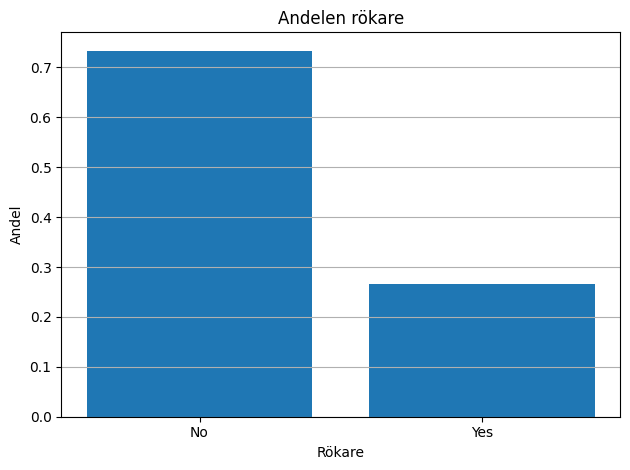

In [5]:
# Stapeldiagram över andelen rökare

smoker_counts = df["smoker"].value_counts(normalize=True)

print(smoker_counts)

fig, ax = plt.subplots()
ax.bar(smoker_counts.index, smoker_counts.values)
ax.set_title('Andelen rökare')
ax.set_xlabel('Rökare')
ax.set_ylabel('Andel')
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()

### Simulering

In [6]:
# Andelen personer i datasetet som har sjukdomen

disease_avg = df["disease"].mean()

print(f"Andelen personer i datasetet som har sjukdomen: {disease_avg}")

# Simulering

np.random.seed(42)

n = 1000
sim = np.random.choice([0, 1], size=n, p=[1 - disease_avg, disease_avg])

sim_avg = sim.mean()

print(f"Andelen personer i simulationen som har sjukdomen: {sim_avg}")

print("Skillnad:", disease_avg - sim_avg)

Andelen personer i datasetet som har sjukdomen: 0.05875
Andelen personer i simulationen som har sjukdomen: 0.056
Skillnad: 0.0027499999999999955


### Konfidensintervall för medelvärdet av systolic_bp

In [7]:
# Metod 1: Normalapproximation

mean_sys = df["systolic_bp"].mean()
std_sys = df["systolic_bp"].std()
n = len(df)
se_sys = std_sys / np.sqrt(n)

print(mean_sys, std_sys, n, se_sys)


149.178625 12.793360316766597 800 0.4523135917074269


In [8]:
def ci_mean_normal(x, confidence=0.95):
    x = np.asarray(x, dtype=float)
    mean_sys = float(x.mean())
    std_sys = float(x.std())
    n = len(x)
    z_critical = 1.96
    half_width = z_critical * std_sys / np.sqrt(n)
    lo, hi = mean_sys - half_width, mean_sys + half_width
    return float(lo), float(hi), mean_sys, std_sys, n

lo, hi, mean_sys, std_sys, n = ci_mean_normal(df["systolic_bp"])

print(f"CI = ({lo:.2f}, {hi:.2f}), mean = {mean_sys:.2f}, std = {std_sys:.2f}, n = {n}")

CI = (148.29, 150.06), mean = 149.18, std = 12.79, n = 800


In [9]:
# Metod 2: Bootstrap

np.random.seed(42)

def ci_mean_bootstrap(x, B=1000, confidence=0.95):
    x = np.asarray(x, dtype=float)
    n = len(x)
    boot_means = np.empty(B)
    for b in range(B):
        boot_sample = np.random.choice(x, size=n)
        boot_means[b] = np.mean(boot_sample)

    alpha = (1 - confidence) / 2
    lo, hi = np.percentile(boot_means, [100*alpha, 100*(1 - alpha)])
    return float(lo), float(hi), float(np.mean(x))

blo, bhi, bmean = ci_mean_bootstrap(df["systolic_bp"])

print(f"CI bootstrap = ({blo:.2f}, {bhi:.2f}), mean = {bmean:.2f}")

CI bootstrap = (148.31, 150.10), mean = 149.18


In [10]:
# Jamför resultaten

print(f"CI = ({lo:.2f}, {hi:.2f})")
print(f"CI bootstrap = ({blo:.2f}, {bhi:.2f})")


CI = (148.29, 150.06)
CI bootstrap = (148.31, 150.10)


Resultat:
De två konfidensintervallen (normalapproximation och bootstrap) är nästan identiska. Det tyder på att våra data ligger nära en normalfördelning.

### Hypotesprövning

Hypoteser:
- H0 (nollhypotes): Rökare har inte högre medel-blodtryck än icke-rökare
- H1 (ensidig): Rökare har högre medel-blodtryck än icke-rökare

In [11]:
mean_smokers = df.loc[df['smoker'] == 'Yes', 'systolic_bp'].mean()
mean_nonsmokers = df.loc[df['smoker'] == 'No', 'systolic_bp'].mean()

print("Medel-blodtryck rökare:", mean_smokers)
print("Medel-blodtryck icke-rökare:", mean_nonsmokers)

Medel-blodtryck rökare: 149.524882629108
Medel-blodtryck icke-rökare: 149.05298126064736


Standard t-test:

In [12]:
smoker = df.loc[df["smoker"]=="Yes", "systolic_bp"].values
nonsmoker = df.loc[df["smoker"]=="No", "systolic_bp"].values

# Standard t-test
t_stat, p_value = stats.ttest_ind(smoker, nonsmoker, alternative='greater')

print(f"Standard t-test: t = {t_stat:.3f}, p = {p_value:.4f}")



Standard t-test: t = 0.461, p = 0.3225


- P-värdet (0.3225) är större än signifikansnivån 0.05, vilket innebär att vi inte kan förkasta nollhypotesen.  
- Det finns alltså ingen statistiskt signifikant evidens för att rökare har högre medelvärde av systoliskt blodtryck än icke-rökare i detta dataset.
- Skillnaden som observerats är liten och kan förklaras av slumpen.

### Power

- Simulering för att undersöka hur säkert hypotes­testet är (t.ex. hur ofta testet hittar en skillnad när den finns → power).

In [13]:
from statsmodels.stats.power import TTestIndPower

n_smokers = int((df["smoker"] == "Yes").sum())                                       # antal rökare
n_nonsmokers = int((df["smoker"] == "No").sum())                                     # antal icke-rökare

std_smokers = df.loc[df["smoker"] == "Yes", "systolic_bp"].std()                     # standardavvikelse rökare
std_nonsmokers = df.loc[df["smoker"] == "No", "systolic_bp"].std()                   # standardavvikelse icke-rökare

mean_smokers = df.loc[df['smoker'] == 'Yes', 'systolic_bp'].mean()                   # sanna medel rökare
mean_nonsmokers = df.loc[df['smoker'] == 'No', 'systolic_bp'].mean()                 # sanna medel icke-rökare

sd_pooled = np.sqrt(                                                                 # ungefärlig gemensam standardavvikelse
    ((n_smokers - 1)*std_smokers**2 + (n_nonsmokers - 1)*std_nonsmokers**2) /
    (n_smokers + n_nonsmokers - 2)
    )     
                                                              
d = (mean_smokers - mean_nonsmokers) / sd_pooled                                     # Effektstorlek (Cohen's d)
alpha = 0.05

power_t = TTestIndPower().power(effect_size=d,
                                nobs1=n_smokers,
                                alpha=alpha,
                                ratio=n_nonsmokers / n_smokers,
                                alternative="larger")


print(f"Power: {power_t:.3f}")

Power: 0.118


**Slutsatser:**
- Jag beräknade hur säkert hypotestestet är med funktionen `TTestIndPower` från statsmodels.  
- Effektstorleken (Cohen’s d) baseras på skillnaden i medelvärde mellan rökare (149.52 mmHg) och icke-rökare (149.05 mmHg).  
- Eftersom skillnaden mellan medelvärden är mycket liten, kommer Cohen's d bli mycket liten, vilket betyder låg power.
- Den beräknade powern är cirka **0.118**, vilket betyder att testet bara har ca **11,8 % chans** att upptäcka en verklig skillnad i systoliskt blodtryck mellan rökare och icke-rökare om den finns.  
- Detta tyder på att testet är **svagt** (låg power), och att ett större urval eller en tydligare skillnad krävs för att kunna hitta ett verkligt samband.


**Källor:**
1. https://www.statsmodels.org/stable/generated/statsmodels.stats.power.TTestIndPower.power.html
2. https://how-to-data.org/how-to-compute-the-power-of-a-test-comparing-two-population-means-in-python-using-statsmodels/
3. https://www.geeksforgeeks.org/python/introduction-to-power-analysis-in-python/